## 1- Extraction des tweets

In [ ]:
#Importation des bibliothèques
! pip install wordcloud
!pip install snscrape
!pip install unidecode
import snscrape.modules.twitter as sntwitter
import seaborn as sns
import pandas as pd
import csv
import matplotlib.pyplot as plt

from unidecode import unidecode
from nltk.stem import SnowballStemmer
import re
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
##Création d'un csv contenant ~50 000 tweets concernant le Covid.
#On stock en information la date, l'utilisateur, le nombre de likes, le nombre de retweets, le nombre de réponses et le nombre d efois où le tweet a été cité.
# csvFile = open('./TweetScrapResult.csv', 'a', newline='', encoding='utf8')
# csvWriter = csv.writer(csvFile)
# csvWriter.writerow(['id','user','date','tweet', 'like', 'retweet', 'reply', 'quote']) 

# for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Covid OR #Coronavirus lang:fr + since:2021-01-01 until:2022-01-01 -filter:links - -filter:replies').get_items()):
#         csvWriter.writerow([tweet.id, tweet.user.username, tweet.date,  tweet.content.replace("\n", " "), tweet.likeCount, tweet.retweetCount, tweet.replyCount, tweet.quoteCount])
# csvFile.close()

In [ ]:
df=pd.read_csv('./TweetScrapResultRetweets.csv')
df.head(5).append(df.tail(5))

,id,user,date,tweet,like,retweet,reply,quote
0,1477065731644739588,SLassalle,2021-12-31 23:54:47+00:00,Non seulement le @GouvQc nous nique notre réve...,2,0,0,0
1,1477064231451348996,EvelyneLavallee,2021-12-31 23:48:49+00:00,Je vais souhaiter une année de merde. Comme ça...,1,0,0,0
2,1477063987883913227,Muhiresaka,2021-12-31 23:47:51+00:00,Churches are the new bars in this NYE in Buja....,17,0,3,0
3,1477063959735934979,Krapoute,2021-12-31 23:47:45+00:00,Une alerte de sécurité pour annoncer votre ost...,1,0,0,0
4,1477063789237489667,Bibiz9944x,2021-12-31 23:47:04+00:00,. @francoislegault VA CHIER MON TABARNAK #Ale...,3,0,0,0
50695,1344799331975626753,VxkyaFN,2021-01-01 00:15:20+00:00,A tout le monde !! Je vous souhaite une très b...,0,0,0,0
50696,1344798508910567430,atirlarigot,2021-01-01 00:12:04+00:00,Au lieu de vous plaindre les #francais que vou...,0,0,0,0
50697,1344797009459507200,baptistecoppey,2021-01-01 00:06:06+00:00,"En ce 1er jour de 2021, qu’est-ce que j’aimera...",7,0,1,0
50698,1344796694446297092,Nathan_Vltt,2021-01-01 00:04:51+00:00,Mes meilleurs vœux pour cette nouvelle année l...,6,0,0,0
50699,1344795577545056256,Mediavenir,2021-01-01 00:00:25+00:00,🌐 FLASH - 14 000 personnes sont mortes de la #...,4396,540,165,221


## 2 - Analyse descriptive

In [ ]:
print(f"Notre DataFrame fait {df.shape[0]} lignes et {df.shape[1]} colonnes" )

Notre DataFrame fait 50700 lignes et 8 colonnes


In [ ]:
#On regarde le nombre de doublons
df.tweet.duplicated().sum()

0

In [ ]:
# On analyse les colonnes : le type des variables et les valeurs non fournies
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50700 entries, 0 to 50699
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50700 non-null  int64 
 1   user     50700 non-null  object
 2   date     50700 non-null  object
 3   tweet    50700 non-null  object
 4   like     50700 non-null  int64 
 5   retweet  50700 non-null  int64 
 6   reply    50700 non-null  int64 
 7   quote    50700 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 3.1+ MB


In [ ]:
# On transforme le type de la date en datetime et on créé les colonnes année et mois
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

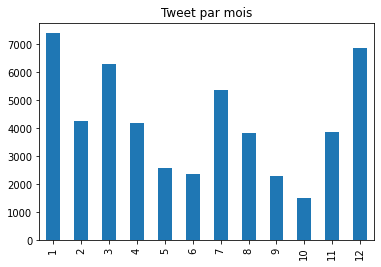

In [ ]:
# On observe la répartition des tweets en fonction du mois
df['month'].value_counts(sort=False).plot(kind="bar")
plt.title('Tweet par mois')
plt.show()

In [ ]:
# on récupère l'ensemble des hashtags utilisés dans les tweets
hashtags = []
dates = []
for tweet, date in zip(df['tweet'], df['date']):
    tweet_arr = tweet.split(" ")
    for word in tweet_arr:
        if word.find("#") != -1 and word.lower().find("covid") == -1 and word.lower().find("coronavirus") == -1:
            hashtags.append(word)
            dates.append(date)
df_hashtags = pd.DataFrame(data = {"hashtag" : hashtags, "date" : dates})
df_hashtags['date'] = pd.to_datetime(df_hashtags['date'], format='%Y-%m-%d %H:%M:%S')
df_hashtags['year'] = df_hashtags['date'].dt.year
df_hashtags['month'] = df_hashtags['date'].dt.month
df_hashtags

,hashtag,date,year,month
0,#AlertAmber,2021-12-31 23:54:47+00:00,2021,12
1,#couvrefeu,2021-12-31 23:54:47+00:00,2021,12
2,#Quebec,2021-12-31 23:54:47+00:00,2021,12
3,#annee2022,2021-12-31 23:48:49+00:00,2021,12
4,#pasdenoel,2021-12-31 23:48:49+00:00,2021,12
...,...,...,...,...
93028,#nouvelan2021,2021-01-01 00:12:04+00:00,2021,1
93029,#medias,2021-01-01 00:06:06+00:00,2021,1
93030,#HappyNewYear2021,2021-01-01 00:06:06+00:00,2021,1
93031,#HAPPYNEWYEAR,2021-01-01 00:06:06+00:00,2021,1


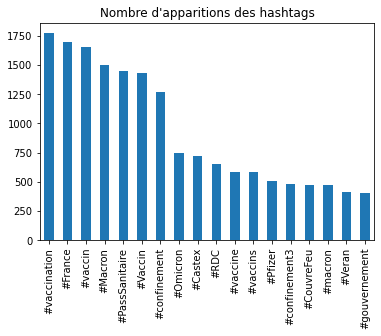

In [ ]:
# On observe les hashtags les plus répandus
df_hashtags.groupby("hashtag").filter(lambda x : len(x) > 400).hashtag.value_counts(sort=True).plot(kind="bar")
plt.title("Nombre d'apparitions des hashtags")
plt.show()

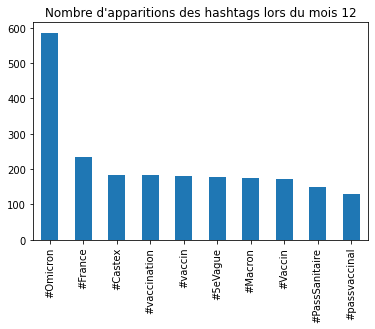

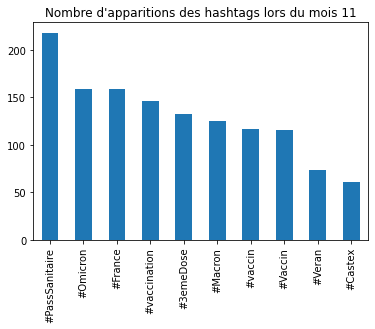

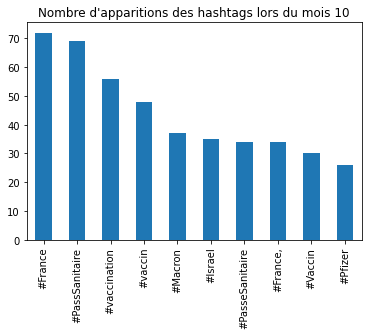

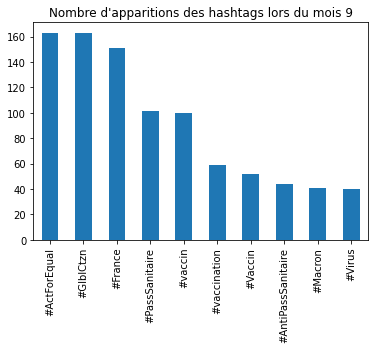

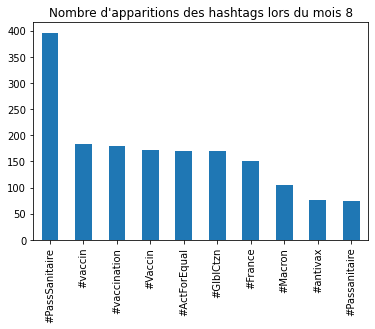

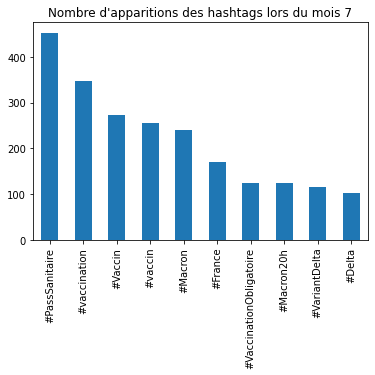

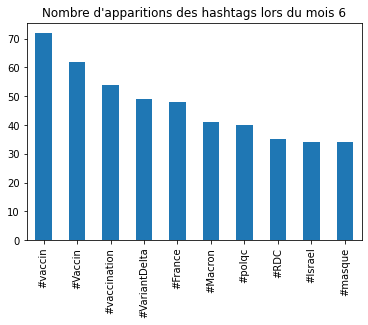

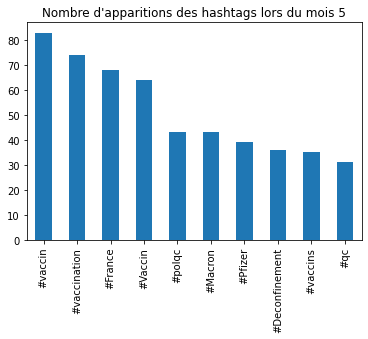

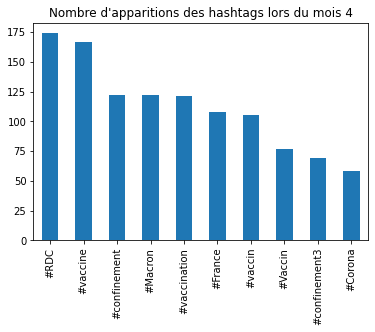

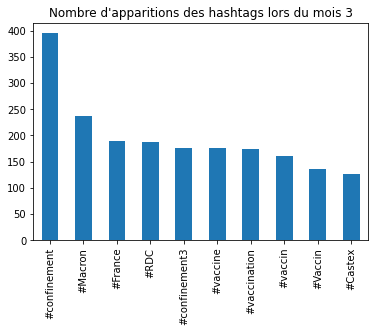

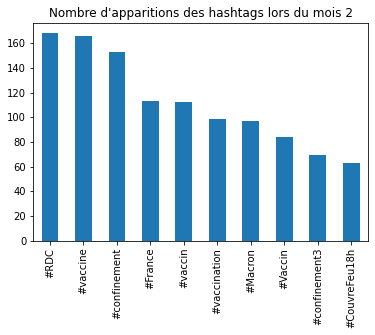

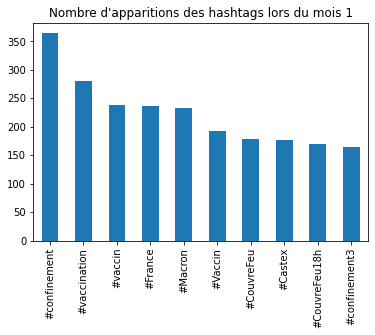

In [ ]:
for month in df_hashtags.month.unique():
    df_hashtags[df_hashtags['month']==month].hashtag.value_counts(sort=True)[:10].plot(kind="bar")
    plt.title(f"Nombre d'apparitions des hashtags lors du mois {month}")
    plt.show()

In [ ]:
# Définition de la liste de stop words considérés (celle de spacy + lettres)
stopWords = ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'ailleurs', 'ainsi', 'ait', 'allaient', 'allo', 'allons', 
             'allô', 'alors', 'anterieur', 'anterieure', 'anterieures', 'apres', 'après', 'as', 'assez', 'attendu', 'au', 
             'aucun', 'aucune', 'aujourd', "aujourd'hui", 'aupres', 'auquel', 'aura', 'auraient', 'aurait', 'auront', 'aussi', 
             'autre', 'autrefois', 'autrement', 'autres', 'autrui', 'aux', 'auxquelles', 'auxquels', 'avaient', 'avais', 'avait', 
             'avant', 'avec', 'avoir', 'avons', 'ayant', 'bah', 'bas', 'basee', 'bat', 'beau', 'beaucoup', 'bien', 'bigre', 'boum', 
             'bravo', 'brrr', "c'", 'car', 'ce', 'ceci', 'cela', 'celle', 'celle-ci', 'celle-là', 'celles', 'celles-ci', 'celles-là', 
             'celui', 'celui-ci', 'celui-là', 'cent', 'cependant', 'certain', 'certaine', 'certaines', 'certains', 'certes', 'ces', 
             'cet', 'cette', 'ceux', 'ceux-ci', 'ceux-là', 'chacun', 'chacune', 'chaque', 'cher', 'chers', 'chez', 'chiche', 'chut', 
             'chère', 'chères', 'ci', 'cinq', 'cinquantaine', 'cinquante', 'cinquantième', 'cinquième', 'clac', 'clic', 'combien', 
             'comme', 'comment', 'comparable', 'comparables', 'compris', 'concernant', 'contre', 'couic', 'crac', 'c’', "d'", 'da', 
             'dans', 'de', 'debout', 'dedans', 'dehors', 'deja', 'delà', 'depuis', 'dernier', 'derniere', 'derriere', 'derrière', 
             'des', 'desormais', 'desquelles', 'desquels', 'dessous', 'dessus', 'deux', 'deuxième', 'deuxièmement', 'devant', 'devers', 
             'devra', 'different', 'differentes', 'differents', 'différent', 'différente', 'différentes', 'différents', 'dire', 
             'directe', 'directement', 'dit', 'dite', 'dits', 'divers', 'diverse', 'diverses', 'dix', 'dix-huit', 'dix-neuf', 
             'dix-sept', 'dixième', 'doit', 'doivent', 'donc', 'dont', 'douze', 'douzième', 'dring', 'du', 'duquel', 'durant', 'dès', 
             'désormais', 'd’', 'effet', 'egale', 'egalement', 'egales', 'eh', 'elle', 'elle-même', 'elles', 'elles-mêmes', 'en', 
             'encore', 'enfin', 'entre', 'envers', 'environ', 'es', 'est', 'et', 'etaient', 'etais', 'etait', 'etant', 'etc', 'etre', 
             'eu', 'euh', 'eux', 'eux-mêmes', 'exactement', 'excepté', 'extenso', 'exterieur', 'fais', 'faisaient', 'faisant', 'fait', 
             'façon', 'feront', 'fi', 'flac', 'floc', 'font', 'gens', 'ha', 'hein', 'hem', 'hep', 'hi', 'ho', 'holà', 'hop', 'hormis', 
             'hors', 'hou', 'houp', 'hue', 'hui', 'huit', 'huitième', 'hum', 'hurrah', 'hé', 'hélas', 'i', 'il', 'ils', 'importe', 
             "j'", 'je', 'jusqu', 'jusque', 'juste', 'j’', "l'", 'la', 'laisser', 'laquelle', 'las', 'le', 'lequel', 'les', 
             'lesquelles', 'lesquels', 'leur', 'leurs', 'longtemps', 'lors', 'lorsque', 'lui', 'lui-meme', 'lui-même', 'là', 'lès', 'l’', 
             "m'", 'ma', 'maint', 'maintenant', 'mais', 'malgre', 'malgré', 'maximale', 'me', 'meme', 'memes', 'merci', 'mes', 'mien', 'mienne', 
             'miennes', 'miens', 'mille', 'mince', 'minimale', 'moi', 'moi-meme', 'moi-même', 'moindres', 'moins', 'mon', 
             'moyennant', 'même', 'mêmes', 'm’', "n'", 'na', 'naturel', 'naturelle', 'naturelles', 'ne', 'neanmoins', 'necessaire', 
             'necessairement', 'neuf', 'neuvième', 'ni', 'nombreuses', 'nombreux', 'non', 'nos', 'notamment', 'notre', 'nous', 'nous-mêmes', 
             'nouveau', 'nul', 'néanmoins', 'nôtre', 'nôtres', 'n’', 'o', 'oh', 'ohé', 'ollé', 'olé', 'on', 'ont', 'onze', 'onzième', 'ore', 
             'ou', 'ouf', 'ouias', 'oust', 'ouste', 'outre', 'ouvert', 'ouverte', 'ouverts', 'où', 'paf', 'pan', 'par', 'parce', 'parfois', 
             'parle', 'parlent', 'parler', 'parmi', 'parseme', 'partant', 'particulier', 'particulière', 'particulièrement', 'pas', 'passé', 
             'pendant', 'pense', 'permet', 'personne', 'peu', 'peut', 'peuvent', 'peux', 'pff', 'pfft', 'pfut', 'pif', 'pire', 'plein', 'plouf', 
             'plus', 'plusieurs', 'plutôt', 'possessif', 'possessifs', 'possible', 'possibles', 'pouah', 'pour', 'pourquoi', 'pourrais', 'pourrait', 
             'pouvait', 'prealable', 'precisement', 'premier', 'première', 'premièrement', 'pres', 'probable', 'probante', 'procedant', 'proche', 
             'près', 'psitt', 'pu', 'puis', 'puisque', 'pur', 'pure', "qu'", 'quand', 'quant', 'quant-à-soi', 'quanta', 'quarante', 'quatorze', 
             'quatre', 'quatre-vingt', 'quatrième', 'quatrièmement', 'que', 'quel', 'quelconque', 'quelle', 'quelles', "quelqu'un", 'quelque', 
             'quelques', 'quels', 'qui', 'quiconque', 'quinze', 'quoi', 'quoique', 'qu’', 'rare', 'rarement', 'rares', 'relative', 'relativement', 
             'remarquable', 'rend', 'rendre', 'restant', 'reste', 'restent', 'restrictif', 'retour', 'revoici', 'revoilà', 'rien', "s'", 'sa', 
             'sacrebleu', 'sait', 'sans', 'sapristi', 'sauf', 'se', 'sein', 'seize', 'selon', 'semblable', 'semblaient', 'semble', 'semblent', 
             'sent', 'sept', 'septième', 'sera', 'seraient', 'serait', 'seront', 'ses', 'seul', 'seule', 'seulement', 'si', 'sien', 'sienne', 
             'siennes', 'siens', 'sinon', 'six', 'sixième', 'soi', 'soi-même', 'soit', 'soixante', 'son', 'sont', 'sous', 'souvent', 'specifique', 
             'specifiques', 'speculatif', 'stop', 'strictement', 'subtiles', 'suffisant', 'suffisante', 'suffit', 'suis', 'suit', 'suivant', 
             'suivante', 'suivantes', 'suivants', 'suivre', 'superpose', 'sur', 'surtout', 's’', "t'", 'ta', 'tac', 'tant', 'tardive', 'te', 
             'tel', 'telle', 'tellement', 'telles', 'tels', 'tenant', 'tend', 'tenir', 'tente', 'tes', 'tic', 'tien', 'tienne', 'tiennes', 
             'tiens', 'toc', 'toi', 'toi-même', 'ton', 'touchant', 'toujours', 'tous', 'tout', 'toute', 'toutefois', 'toutes', 'treize', 'trente', 
             'tres', 'trois', 'troisième', 'troisièmement', 'trop', 'très', 'tsoin', 'tsouin', 'tu', 'té', 't’', 'un', 'une', 'unes', 
             'uniformement', 'unique', 'uniques', 'uns', 'va', 'vais', 'vas', 'vers', 'via', 'vif', 'vifs', 'vingt', 'vivat', 'vive', 'vives', 
             'vlan', 'voici', 'voilà', 'vont', 'vos', 'votre', 'vous', 'vous-mêmes', 'vu', 'vé', 'vôtre', 'vôtres', 'zut', 'à', 'â', 'ça', 'ès', 
             'étaient', 'étais', 'était', 'étant', 'été', 'être', 'ô','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'gt', 'qu', 'covid', 'coronavirus']

stopWords = [unidecode(sw) for sw in stopWords]

# Création du stemmer
stemmer = SnowballStemmer('french')

In [ ]:
# Création d'une fonction pour supprimer les stopwords
def no_stop_word(string, stopWords):

    """
    Supprime les stop words d'un texte.

    Paramètres
    ----------

    string : chaine de caractère.

    stopWords : liste de mots à exclure. 
    """
    
    string = ' '.join([word for word in string.split() if word not in stopWords])
    return string

def stemmatise_text(text, stemmer):

    """
    Stemmatise un texte : Ramène les mots d'un texte à leur racine (peut créer des mots qui n'existe pas).

    Paramètres
    ----------

    text : Chaine de caractères.

    stemmer : Stemmer de NLTK.
    """

    return " ".join([stemmer.stem(word) for word in text.split()])

In [ ]:
def stem_cleaner(pandasSeries, stemmer, stopWords):
    
    print("#### Nettoyage en cours ####") 

    # confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
        
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    # Suppression des accents
    print("... Suppression des accents") 
    pandasSeries = pandasSeries.apply(lambda x : unidecode(x))
    
    # Détection du champs année
    print("... Détection du champs année") 
    pandasSeries = pandasSeries.apply(lambda x : re.sub(r'[0-9]{4}', 'annee', x))
    
    # Suppression des caractères spéciaux et numériques
    print("... Suppression des caractères spéciaux et numériques") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"[^a-z]+", ' ', x))
    
    # Suppression des stop words
    print("... Suppression des stop words") 
    pandasSeries = pandasSeries.apply(lambda x : no_stop_word(x, stopWords))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries

In [ ]:
# On nettoie notre corpus
#%%time 
df['tweet_clean'] = stem_cleaner(df['tweet'], stemmer, stopWords)

df[['tweet', 'tweet_clean']].head()

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression des accents
... Détection du champs année
... Suppression des caractères spéciaux et numériques
... Suppression des stop words
#### Nettoyage OK! ####


,tweet,tweet_clean
0,Non seulement le @GouvQc nous nique notre réve...,gouvqc nique reveillon enfonce clou detournant...
1,Je vais souhaiter une année de merde. Comme ça...,souhaiter annee merde pourra anneeannee pasden...
2,Churches are the new bars in this NYE in Buja....,churches are the new bars in this nye in buja ...
3,Une alerte de sécurité pour annoncer votre ost...,alerte securite annoncer osti couvre feu serie...
4,. @francoislegault VA CHIER MON TABARNAK #Ale...,francoislegault chier tabarnak alertecovid polqc


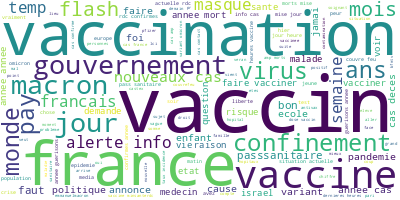

In [ ]:
# On rassemble les différents tweets nettoyés
long_string = ','.join(list(df['tweet_clean'].values))
# On en fait un nuage de mot
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
# Stemmatisation
df['tweet_stem'] = df['tweet_clean'].apply(lambda x : stemmatise_text(x, stemmer))

## 3-Modélisation 

In [ ]:
# On construit notre sac de mot à partir de nos tweets
vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()

# On applique la transformation
tf = vectorizer.fit_transform(df['tweet_stem']).toarray()

# On stocke l'identification des mots par colonnes
tf_feature_names = vectorizer.get_feature_names()

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
score_arr = []
perplex_arr = []

for x in [2, 3, 5, 7, 10, 12]:
    model = LatentDirichletAllocation(n_components=x, random_state=0)
    model.fit(tf)
    score_arr.append(model.score(tf))
    perplex_arr.append(model.perplexity(tf))
    print("Number of topics:", x, "Score:", model.score(tf), "Perplexity:", model.perplexity(tf))
# Number of topics: 2 Score: -5691883.771275694 Perplexity: 3116.7030086947793
# Number of topics: 3 Score: -5676620.441590723 Perplexity: 3050.1889432572925
# Number of topics: 5 Score: -5729510.723452766 Perplexity: 3286.933796979018
# Number of topics: 7 Score: -5735513.129002248 Perplexity: 3314.9367897066254
# Number of topics: 10 Score: -5727522.005898147 Perplexity: 3277.708113023486
# Number of topics: 12 Score: -5731015.867098228 Perplexity: 3293.9334357037965

Number of topics: 2 Score: -5691883.771275695 Perplexity: 3116.703008694785
Number of topics: 3 Score: -5676620.4415907245 Perplexity: 3050.1889432573034
Number of topics: 5 Score: -5729510.7234527655 Perplexity: 3286.933796979012
Number of topics: 7 Score: -5735513.129002249 Perplexity: 3314.9367897066254
Number of topics: 10 Score: -5727522.005898148 Perplexity: 3277.708113023492
Number of topics: 12 Score: -5731015.867098228 Perplexity: 3293.9334357037965


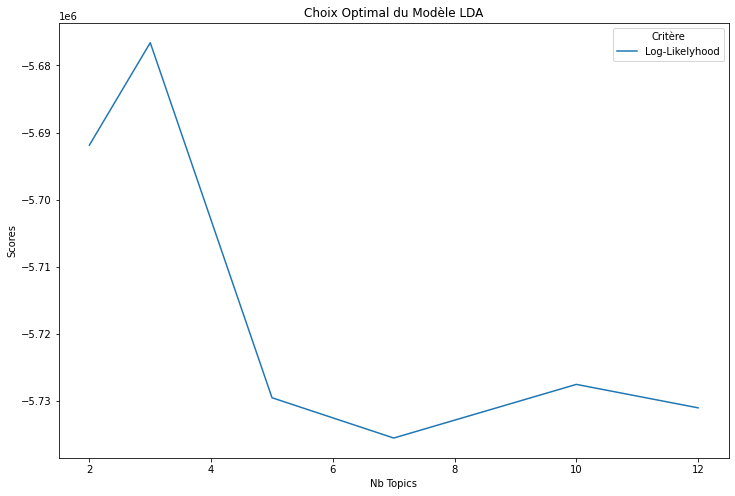

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot([2, 3, 5, 7, 10, 12], score_arr, label='Log-Likelyhood')
plt.title("Choix Optimal du Modèle LDA")
plt.xlabel("Nb Topics")
plt.ylabel("Scores")
plt.legend(title='Critère', loc='best')
plt.show()

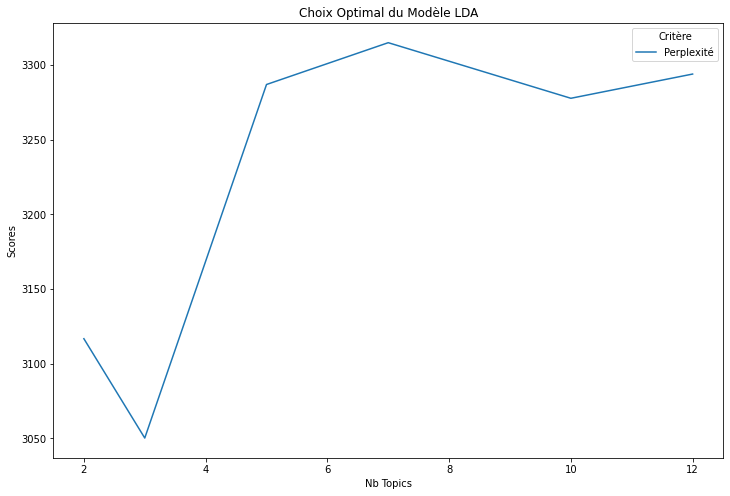

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot([2, 3, 5, 7, 10, 12], perplex_arr, label='Perplexité')
plt.title("Choix Optimal du Modèle LDA")
plt.xlabel("Nb Topics")
plt.ylabel("Scores")
plt.legend(title='Critère', loc='best')
plt.show()

In [ ]:
# On construit des sujets en rassemblant les tweets à partir de leurs mots, puis on attribue un certain poids à chaque mot en fonction du sujet
# On cherche à créer 3 sujets
number_of_topics = 3

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

In [ ]:
lda_output = model.fit_transform(tf)

In [ ]:
# On créé une fonction qui nous permettra de créer une base de données contenant les mots et leurs poids dans chaque sujet

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [ ]:
# on affiche les 10 mots les plus importants de chaque sujet
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,vaccin,19008.7,cas,8372.7,anne,2706.8
1,franc,3180.0,anne,5002.1,confin,2375.8
2,vari,2929.0,franc,4702.4,franc,2092.5
3,dos,2826.7,dec,3378.3,masqu,1840.7
4,an,2323.2,mort,2476.7,macron,1828.3
5,fair,2083.5,alert,1783.5,fair,1807.2
6,test,1679.5,test,1615.0,cris,1510.8
7,macron,1610.2,jour,1614.9,vaccin,1510.7
8,flash,1541.1,flash,1548.5,mond,1435.9
9,virus,1443.2,info,1516.9,jour,1362.1


In [ ]:
# On affiche la répartition des documents et des mots en fonction des sujets
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

matrix = vectorizer.fit_transform(df['tweet_stem'])

display_data = pyLDAvis.sklearn.prepare(model, 
                         matrix,
                        vectorizer)
                        
pyLDAvis.display(display_data)

     |████████████████████████████████| 1.7 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 379 kB 10.9 MB/s 
     |████████████████████████████████| 24.1 MB 10.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=1c6c4466e857601bd1846b9b6dcb84c52e81c9db914baacf822cf9797edd350b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1317 sha256=318d81fb1fa6af8a1cd2ac00e8a7d9aab8e17e25478b9b8fcbb71cc71d0346b9
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' comm

In [ ]:
# On cherche le nombre de clusters optimal à l'aide du critère du coude
max_k = 15
km_scores= []
for i in range(2,max_k):
    km = KMeans(n_clusters=i).fit(lda_output)
    preds = km.predict(lda_output)
    km_scores.append(-km.score(lda_output))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


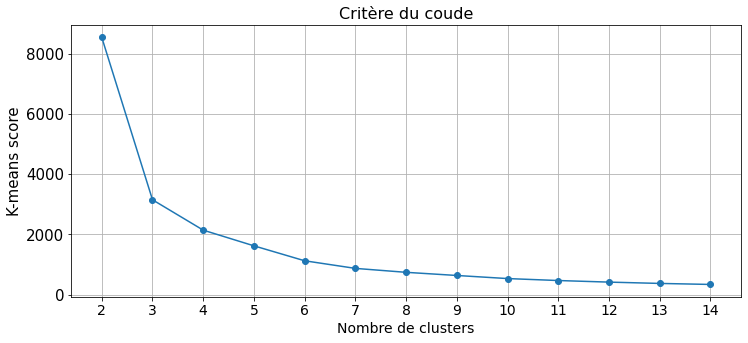

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Critère du coude",fontsize=16)
plt.plot([i for i in range(2,max_k)],km_scores, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,max_k)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# On créé les clusters et catégorisons chaque tweet de notre jeu de données à une de ces catégories
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(lda_output)
clusters = kmeans.labels_
df['clusters'] = clusters
df

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,user,date,tweet,like,retweet,reply,quote,year,month,tweet_clean,tweet_stem,clusters
0,1477065731644739588,SLassalle,2021-12-31 23:54:47+00:00,Non seulement le @GouvQc nous nique notre réve...,2,0,0,0,2021,12,gouvqc nique reveillon enfonce clou detournant...,gouvqc niqu reveillon enfonc clou detourn appl...,0
1,1477064231451348996,EvelyneLavallee,2021-12-31 23:48:49+00:00,Je vais souhaiter une année de merde. Comme ça...,1,0,0,0,2021,12,souhaiter annee merde pourra anneeannee pasden...,souhait anne merd pourr anneeanne pasdenoel is...,0
2,1477063987883913227,Muhiresaka,2021-12-31 23:47:51+00:00,Churches are the new bars in this NYE in Buja....,17,0,3,0,2021,12,churches are the new bars in this nye in buja ...,church are the new bar in this nye in buj egli...,0
3,1477063959735934979,Krapoute,2021-12-31 23:47:45+00:00,Une alerte de sécurité pour annoncer votre ost...,1,0,0,0,2021,12,alerte securite annoncer osti couvre feu serie...,alert securit annonc osti couvr feu serieux ta...,0
4,1477063789237489667,Bibiz9944x,2021-12-31 23:47:04+00:00,. @francoislegault VA CHIER MON TABARNAK #Ale...,3,0,0,0,2021,12,francoislegault chier tabarnak alertecovid polqc,francoislegault chi tabarnak alertecovid polqc,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50695,1344799331975626753,VxkyaFN,2021-01-01 00:15:20+00:00,A tout le monde !! Je vous souhaite une très b...,0,0,0,0,2021,1,monde souhaite bonne annee annee annee annee a...,mond souhait bon anne anne anne anne anne rava...,0
50696,1344798508910567430,atirlarigot,2021-01-01 00:12:04+00:00,Au lieu de vous plaindre les #francais que vou...,0,0,0,0,2021,1,lieu plaindre francais pouvez faire fete soir ...,lieu plaindr franc pouv fair fet soir nouvelan...,0
50697,1344797009459507200,baptistecoppey,2021-01-01 00:06:06+00:00,"En ce 1er jour de 2021, qu’est-ce que j’aimera...",7,0,1,0,2021,1,er jour annee aimerais voir information medias...,er jour anne aim voir inform medi jour happyne...,0
50698,1344796694446297092,Nathan_Vltt,2021-01-01 00:04:51+00:00,Mes meilleurs vœux pour cette nouvelle année l...,6,0,0,0,2021,1,meilleurs voeux nouvelle annee cheris apporte ...,meilleur voeux nouvel anne cher apport bon bon...,0


## 4 - Analyse des clusters

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/root/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/root/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/root/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be

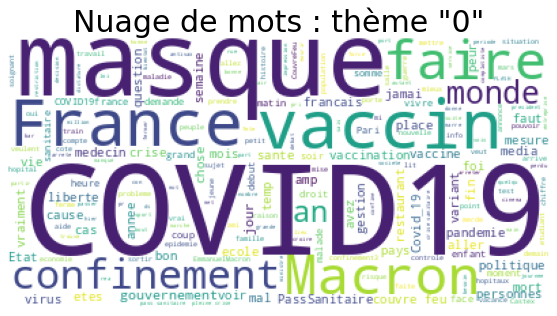

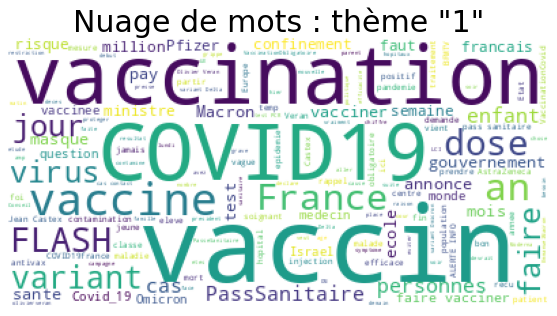

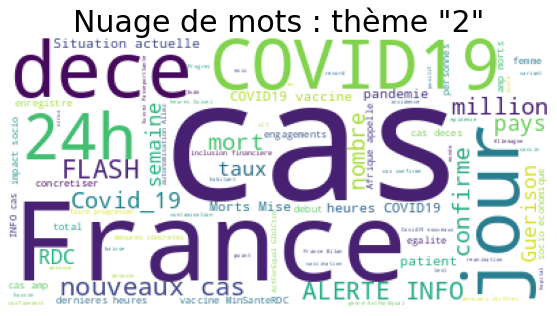

In [ ]:
# On visualise chaque thème grace a un nuage de mot
for thème in df['clusters'].unique():
    
    plt.figure(figsize=(10,5))
    
    text = ','.join(list(df[df['clusters']==thème]["tweet"].apply(lambda x : re.sub(r"[^\w]+", ' ', unidecode(x))).values))
    
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                          contour_color='steelblue', stopwords=stopWords, random_state=42)

    wordcloud.generate(text)

    plt.axis('off')
    plt.title(f'Nuage de mots : thème "{thème}"', fontsize=30)
    plt.imshow(wordcloud)

In [ ]:
# On affiche des tweets type pour chaque thème
for Thème in df['clusters'].unique():
    print(Thème)
    for tweet in df[df['clusters']==Thème]["tweet"].sample(n=10):
        pd.options.display.max_colwidth = len(tweet)
        print(tweet + "\n")

0
🎓 ETUDIANTS I À cause de la difficulté à trouver des #alternances et des #jobs pour la génération #COVID, une pratique se répand : Indiquer les #stages annulés sur son CV.   (Mediapart) #Etudiants

#COVID Apparemment, le Québec serait le seul territoire où il y a un couvre-feu dans toute l'Amérique du nord.  Si c'est vrai, c'est hallucinant.  Ça devrait être au centre de toutes les discussions, de tous les débats à la télé, à la radio, dans les journaux. Me semble… 🤔

Pourquoi les mesures Covid touchent surtout les petites entreprises, discothèques, restaurants?Etrangement ça ressemble aux mesures communistes sous Mao, qui ont tué l'économie des petites entreprise familiales au profit de l'état. Mais ici on détourne le #Covid pour dire que

#martinique @Gendarmerie @PoliceNationale @fdfville @ArsMartinique #chateauboeuf toujours les mecs sont dehors pendant le couvre-feu!!! Jusqu'à côté de la maison des personnes âgées ! ! Après dans l'Ehpad il aura des personnes âgées avec #coronavi

In [ ]:
# On donne un titre à chaque cluster en fonction de son thème

def thematise(cluster) :
    if cluster == 0:
        return "Mesures politiques \n et contestations"
    elif cluster == 1:
        return "Vaccination"
    elif cluster == 2:
        return "Couverture médiatique"

df["Thème"] = df.clusters.apply(lambda x: thematise(x))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

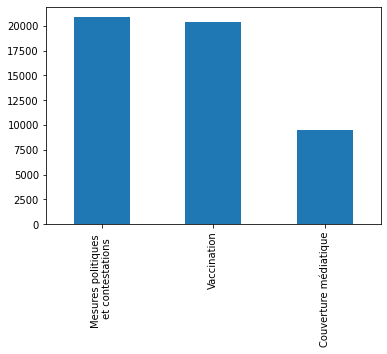

In [ ]:
# On observe le nombre de tweets par thème
df['Thème'].value_counts().plot(kind="bar")

In [ ]:
df['Thème'].value_counts()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mesures politiques \n et contestations    20857
Vaccination                               20371
Couverture médiatique                      9472
Name: Thème, dtype: int64

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


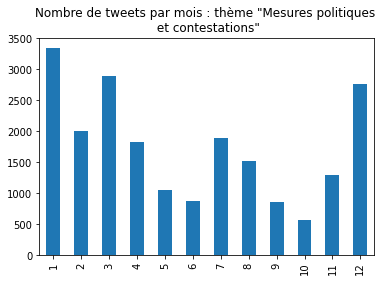

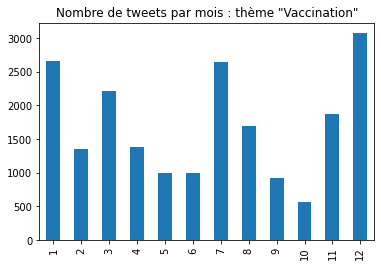

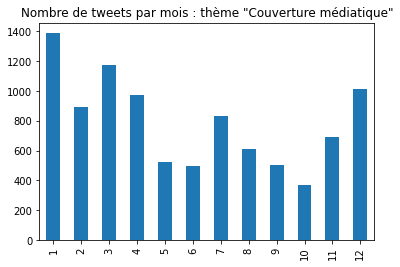

In [ ]:
# On observe a quel mois chaque thème était le plus discuté
for Thème in df['Thème'].unique():
    df_agg = df[df['Thème']==Thème]
    df_plt=df_agg['month'].value_counts(sort=False).sort_index(ascending=True)
    df_plt.plot(kind="bar")
    plt.title(f'Nombre de tweets par mois : thème "{Thème}"')
    plt.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Réponses moyennes par thème')

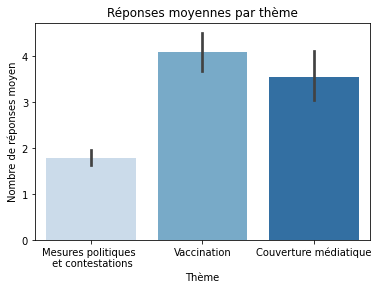

In [ ]:
# On observe le nombre moyen de réponses par thème
sns.barplot(x=df['Thème'], y=df['reply'], palette="Blues")
plt.xlabel('Thème')
plt.ylabel('Nombre de réponses moyen')
plt.title('Réponses moyennes par thème')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Nombres de like moyens par thème')

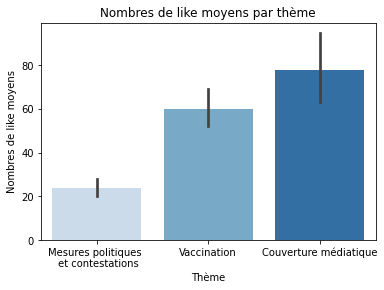

In [ ]:
# On observe le nombre moyen de like par thème
sns.barplot(x=df['Thème'], y=df['like'], palette="Blues")
plt.xlabel('Thème')
plt.ylabel('Nombres de like moyens')
plt.title('Nombres de like moyens par thème')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Retweets moyens par thème')

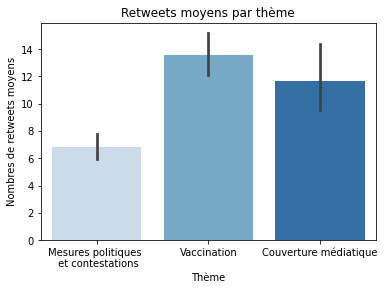

In [ ]:
# On observe le nombre moyen de retweet par thème
sns.barplot(x=df['Thème'], y=df['retweet'], palette="Blues")
plt.xlabel('Thème')
plt.ylabel('Nombres de retweets moyens')
plt.title('Retweets moyens par thème')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a27673d3-3327-42af-9be9-059e8ef931f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>